In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(threshold=np.inf)

In [2]:
#constants
r1, r2, r3, rmax, z1, z2, z3, zmax = 2, 3, 10, 15, -2, 1.5, 3.0, 15
h = 0.1 #0.1 mm grid spacing in r and z
v0, v1, v2 = 0, 0, 2500 #voltage in volts bound (flag 1), outer (flag 2), inner (flag 3)

In [3]:
#generate boundary conditions for the disks in the electron lens
# using the given grid spacing value
def gen_bounds(h):
    jmax = int((rmax/h))
    imax = 2*int((zmax/h))
    flag_grid = np.zeros((imax,jmax)).astype(int)
    #three hard walls of V=0
    flag_grid[:,jmax-1] = 1
    flag_grid[0,:]= 1
    flag_grid[imax-1,:] = 1
    #first plate
    plate_1_z = int(imax/2+z1/h)
    plate_1_rmin = int(r1/h)
    plate_1_rmax = int(r3/h)
    flag_grid[plate_1_z,plate_1_rmin:plate_1_rmax+1] = 2
    #second plate
    plate_2_z = int(imax/2)
    plate_2_rmin = int(r2/h)
    plate_2_rmax = int(r3/h)
    flag_grid[plate_2_z,plate_2_rmin:plate_2_rmax+1] = 3
    #third plate
    plate_3_zmin = int(imax/2+z2/h)
    plate_3_zmax = int(imax/2+z3/h)
    plate_3_rmin = int(r2/h)
    plate_3_rmax = int(r3/h)
    flag_grid[plate_3_zmin:plate_3_zmax,plate_3_rmin:plate_3_rmax+1] = 2
    return flag_grid

In [4]:
#generate initial condition based on flag grid given
#fills potentials based on voltages
def gen_pot(flags):
    potentials = np.zeros(flags.shape)
    for i in range(0,flags.shape[0]):
        for j in range(0,flags.shape[1]):
            if flags[i][j]==1:
                potentials[i][j] = v0
            elif flags[i][j]==2:
                potentials[i][j] = v1
            elif flags[i][j]==3:
                potentials[i][j] = v2
    return potentials

In [5]:
#do one cycle of the laplace equation relaxation update
#return updated potentials and max change
#uses a Gauss-Seidel method for weighted update, omega is relaxation parameter
def update_potentials(pot, flags, omega):
   #loop through to update potential based on laplace equation
    temp = 0.0
    maxchange = 0.0
    for i in range(1,pot.shape[0]-1):
        for j in range(1,pot.shape[1]-1):
            #check flag
            if flags[i][j]==0:
                #calculate 
                term1 = .25*(pot[i][j+1]+pot[i][j-1]+pot[i+1][j]+pot[i-1][j])
                term2 = .125*(pot[i][j+1]-pot[i][j-1])/j
                temp = term1+term2
                #update maxchange
                delta = abs(pot[i][j]-temp)
                if delta>maxchange:
                    maxchange = delta
                #update weighted by gauss-seidel relaxation param
#                 outpot[i][j] = (1-omega)*pot[i][j]+omega*outpot[i][j]
                pot[i][j] = (1.0-omega)*pot[i][j]+omega*temp
            else:
                pass #don't change value of boundary condition
    #on-axis special condition
    for i in range(1,pot.shape[0]-1):
        #check flag
        if flags[i][0]==0:
            temp = (4*pot[i][1]+pot[i+1][0]+pot[i-1][0])/6
            #update maxchange
            delta = abs(pot[i][j]-temp)
            if delta>maxchange:
                maxchange = delta
            #update weighted by gauss-seidel relaxation param
#             outpot[i][j] = (1-omega)*pot[i][j]+omega*outpot[i][j]
            pot[i][j] = (1.0-omega)*pot[i][j]+omega*temp
        else:
            pass #don't change value of boundary condition 
    return pot, maxchange

In [6]:
#continue updating potential until a tolerance is reached
def calculate_potential(pot, flags, tol, omega):
    change = tol+1
    iterations = 0
    max_iter = 100
    while change>tol and iterations<max_iter:
        pot, change = update_potentials(pot, flags, omega)
        iterations += 1 
    return (pot, iterations)

100


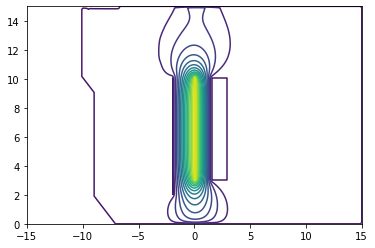

In [7]:
h = .1
tolerance = 1
omega = 1.9
flags = gen_bounds(h) #gen bounds with resolution h
potential = gen_pot(flags) #gen potentials based on bounds
final_field, nits = calculate_potential(potential, flags, tolerance, omega) #generate final field
# plot setup and show
r = np.linspace(0,rmax,int(rmax/h))
z = np.linspace(-zmax,zmax,2*int(zmax/h)) 
plt.contour(z,r,np.swapaxes(final_field,0,1),20);
print(nits)

In [ ]:
r = np.linspace(0,rmax,int(rmax/h))
z = np.linspace(-zmax,zmax,2*int(zmax/h)) 
plt.contour(z,r,np.swapaxes(final_field,0,1),10);

In [ ]:
num_pts = 20
x = np.linspace(0.1,0.9,num_pts)
iterations = np.zeros(num_pts)
for i in range(0,num_pts):
    _, nits = calculate_potential(potential, flags, tolerance, x[i])
    iterations[i] = nits
plt.plot(x,iterations)